# Importing the Libraries

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

#For UI
import ipywidgets as widgets
from IPython.display import display, clear_output

# Loading the Dataset

In [ ]:
df = pd.read_csv('cardiovascular_risk.csv')
print("Shape:", data.shape)
print("Columns:", list(df.columns))
display(df.head())

Shape: (1025, 14)
Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


# Handling Missing Values

In [ ]:
print("Missing values per column:")
print(df.isna().sum())

Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


# Data Cleaning

In [ ]:
before = len(df)
df = df.drop_duplicates().reset_index(drop=True)
print(f"Dropped duplicates: {before - len(df)}")

# Ensure target exists
assert "target" in df.columns, "Expected 'target' column not found."

Dropped duplicates: 0


# Features and Target

In [ ]:
X = df.drop(columns=["target"])
y = df["target"].astype(int)

print("Target distribution (%):")
print((y.value_counts(normalize=True) * 100).round(2))

Target distribution (%):
target
1    54.3
0    45.7
Name: proportion, dtype: float64


# Splitting Data into Training Set and Test Set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Model Definitions

In [ ]:
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, solver="lbfgs"))
])

rf = Pipeline([
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
])

# Cross-validated ROC-AUC on training data

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logreg_cv = cross_val_score(logreg, X_train, y_train, cv=cv, scoring="roc_auc")
rf_cv = cross_val_score(rf, X_train, y_train, cv=cv, scoring="roc_auc")

print("CV ROC-AUC (train folds):")
print(f"Logistic Regression: mean={logreg_cv.mean():.3f} ± {logreg_cv.std():.3f}")
print(f"Random Forest      : mean={rf_cv.mean():.3f} ± {rf_cv.std():.3f}")

CV ROC-AUC (train folds):
Logistic Regression: mean=0.901 ± 0.050
Random Forest      : mean=0.916 ± 0.046


# Fitting on full Training Set

In [ ]:
logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)

Pipeline(steps=[('clf',
                 RandomForestClassifier(n_estimators=300, n_jobs=-1,
                                        random_state=42))])

## Evaluation

In [ ]:
def eval_model(name, model):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_score)
    print(f"\n{name} - Test Accuracy: {acc:.3f}, ROC-AUC: {auc_val:.3f}")
    print("Classification report:")
    print(classification_report(y_test, y_pred, digits=3))
    return y_pred, y_score, acc, auc_val

y_pred_lr, y_score_lr, acc_lr, auc_lr = eval_model("Logistic Regression", logreg)
y_pred_rf, y_score_rf, acc_rf, auc_rf = eval_model("Random Forest", rf)


Logistic Regression - Test Accuracy: 0.803, ROC-AUC: 0.875
Classification report:
              precision    recall  f1-score   support

           0      0.833     0.714     0.769        35
           1      0.783     0.878     0.828        41

    accuracy                          0.803        76
   macro avg      0.808     0.796     0.798        76
weighted avg      0.806     0.803     0.801        76


Random Forest - Test Accuracy: 0.816, ROC-AUC: 0.869
Classification report:
              precision    recall  f1-score   support

           0      0.818     0.771     0.794        35
           1      0.814     0.854     0.833        41

    accuracy                          0.816        76
   macro avg      0.816     0.813     0.814        76
weighted avg      0.816     0.816     0.815        76



# Selection by ROC_AUC

In [ ]:
best_model = rf if auc_rf >= auc_lr else logreg
best_name = "Random Forest" if best_model is rf else "Logistic Regression"
print(f"Best model selected by ROC-AUC: {best_name}")

Best model selected by ROC-AUC: Logistic Regression


# Plotting Confusion Matrix and ROC Curve for best model

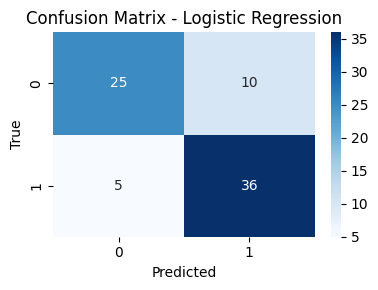

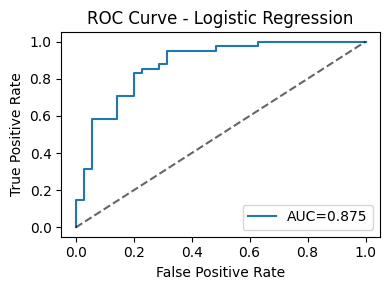

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

def plot_roc(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(4,3))
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
    plt.plot([0,1], [0,1], "k--", alpha=0.6)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

if best_model is rf:
    plot_confusion_matrix(y_test, y_pred_rf, f"Confusion Matrix - {best_name}")
    plot_roc(y_test, y_score_rf, f"ROC Curve - {best_name}")
else:
    plot_confusion_matrix(y_test, y_pred_lr, f"Confusion Matrix - {best_name}")
    plot_roc(y_test, y_score_lr, f"ROC Curve - {best_name}")

# Prediction

In [ ]:
age_w = widgets.BoundedIntText(value=50, min=0, max=120, description="Age")
sex_w = widgets.Dropdown(options=[("Male(1)",1), ("Female(0)",0)], value=1, description="Sex")
cp_w = widgets.BoundedIntText(value=0, min=0, max=3, description="CP")
trestbps_w = widgets.BoundedIntText(value=130, min=0, max=300, description="trestbps")
chol_w = widgets.BoundedIntText(value=240, min=0, max=800, description="chol")
fbs_w = widgets.BoundedIntText(value=0, min=0, max=1, description="fbs")
restecg_w = widgets.BoundedIntText(value=0, min=0, max=2, description="restecg")
thalach_w = widgets.BoundedIntText(value=150, min=0, max=300, description="thalach")
exang_w = widgets.BoundedIntText(value=0, min=0, max=1, description="exang")
oldpeak_w = widgets.FloatText(value=1.0, description="oldpeak")
slope_w = widgets.BoundedIntText(value=1, min=0, max=2, description="slope")
ca_w = widgets.BoundedIntText(value=0, min=0, max=4, description="ca")
thal_w = widgets.BoundedIntText(value=2, min=0, max=3, description="thal")

predict_btn = widgets.Button(description="Predict", button_style="primary")
out = widgets.Output()

def on_predict_clicked(b):
    with out:
        clear_output()
        # Arrange input in same column order as training
        input_values = [
            age_w.value, sex_w.value, cp_w.value, trestbps_w.value, chol_w.value,
            fbs_w.value, restecg_w.value, thalach_w.value, exang_w.value, oldpeak_w.value,
            slope_w.value, ca_w.value, thal_w.value
        ]
        sample = pd.DataFrame([input_values], columns=X.columns)
        # Prediction
        pred = best_model.predict(sample)[0]
        proba = best_model.predict_proba(sample)[0,1] if hasattr(best_model, "predict_proba") else None
        label = "Has heart disease" if pred == 1 else "No heart disease"
        print("Prediction:", label)
        if proba is not None:
            print(f"Probability of class=1 (heart disease): {proba:.3f}")

predict_btn.on_click(on_predict_clicked)

ui = widgets.VBox([
    widgets.HTML("<b>Enter values for prediction</b>"),
    age_w, sex_w, cp_w, trestbps_w, chol_w, fbs_w, restecg_w, thalach_w,
    exang_w, oldpeak_w, slope_w, ca_w, thal_w,
    predict_btn, out
])

display(ui)